#   Political Bias Detection in News Articles 

**Key Features:**

- Bias Classification: Predict if a news article leans left, lean left, center, lean right, or right based on its content.

- Bias vs Source Insights: Explore relationships between news sources and political bias.

- TF-IDF + Machine Learning: Build models to classify political bias using text vectorization.

**Tech Stack & Skills**
- Languages/Libraries:	Python, Pandas, Scikit-learn

- NLP Tools:	NLTK (text cleaning, stemming, stopwords), TF-IDF

- Modeling:	Logistic Regression, Naive Bayes, Decision Trees

- Visualization:	Seaborn, Matplotlib



### Dataset Overview
Source: Kaggle

Name: [Political Bias](https://www.kaggle.com/datasets/mayobanexsantana/political-bias/data)

Size: 3,200+ entries

Key Features: Title, Link, Text, Source, Bias 

Use Cases: Bias audit, Class imbalance handling 

### Intro to the Dataset & Library Setup
#### Import Necessary Libraries

In [1]:
# General Utilities 
import warnings 
warnings.filterwarnings('ignore') # to suppress warnings

import pandas as pd # Data Manipulation and Analysis
import numpy as np # Numerical Operations
import re, string

# Visualizations 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

# Machine Learning & Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

#NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')


# Statistical Testing
import scipy.stats as stats 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/quadrillionaiire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Data Ingestion & Initial Exploration
Understand the dataset's shape, schema, and general info before cleaning or analysis

In [2]:
df = pd.read_csv("../data/Political_Bias.csv", encoding='utf-8') # Load with UTF-8 for character safety
df.head()

,Title,Link,Text,Source,Bias
0,John Boltonâ€™s Advice for the â€˜Continuing T...,https://thedispatch.com/article/john-boltons-a...,"With just days until his inauguration, it woul...",TheDispatch,lean right
1,Why Shrubland Makes Southern Californiaâ€™s Wi...,https://thedispatch.com/newsletter/techne/why-...,"Welcome back to Techne! In Star Trek, writers ...",TheDispatch,lean right
2,Los Angelesâ€™ Destruction Was Fueled by Bad P...,https://thedispatch.com/newsletter/capitolism/...,"As fire still rages in the Los Angeles area, I...",TheDispatch,lean right
3,Acquiring Greenland Is a Good Idea. Threatenin...,https://thedispatch.com/article/acquiring-gree...,"Whether it was Will Rogers or Tony Soprano, th...",TheDispatch,lean right
4,Assessing Trumpâ€™s Expansionist Designs,https://thedispatch.com/newsletter/morning/ass...,"Happy Friday! If anyone was wondering, Belgium...",TheDispatch,lean right


In [3]:
# Display column names, number of entries, and data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   3458 non-null   object
 1   Link    3458 non-null   object
 2   Text    3397 non-null   object
 3   Source  3458 non-null   object
 4   Bias    3458 non-null   object
dtypes: object(5)
memory usage: 135.2+ KB


There are 5 columns, and 3458 rows that have values in every column except `text`, which has 3,397 non null entries. This indicates that our data is mostly complete and only the `text` column is missing some values. We can quickly verify the missing values using df.isnull().sum() to see exactly which columns need attention.

#### Column Name & Description (Sourced From Kaggle)
- **Title** The Title of the article (String)
- **Link** The link to the article webpage (string)
- **Text** Article Text (String)
- **Source** Newspaper name (String)
- **Bias** Political Bias (String)

In [4]:
df.isnull().sum()

Title      0
Link       0
Text      61
Source     0
Bias       0
dtype: int64

In [5]:
df.shape

(3458, 5)

#### Key points Summary
- The dataset has 3458 entries across 5 columns, all object types.

- Text column has 61 missing or malformed rows (e.g., "Error fetching article").

- Target column Bias is multiclass and may be imbalanced.

- Text data needs cleaning, preprocessing, and tokenization.

- Potential ethical concerns: publication tone/style could influence the model more than ideological content.

### Rapid EDA
- Null or Malformed Text
- Class imbalance in Bias
- Source Distribution
- Article Length Distribution

In [6]:
# Length of original (to compare for later)
df['original_length'] = df['Text'].str.len()
df['original_length'].value_counts()

original_length
22.0       633
2789.0       6
2546.0       6
2222.0       6
2900.0       5
          ... 
9162.0       1
4516.0       1
13100.0      1
6397.0       1
2906.0       1
Name: count, Length: 2089, dtype: int64

In [7]:
# Nulls and Malformed
# Count missing and malformed
print(df['Text'].isnull().sum())
print((df['Text'] == "Error fetching article").sum())



61
632


The dataset contains 61 null values and 632 malformed entries labeled as "Error fetching article", which will need to be removed or replaced before training. 

In [8]:
# Class imbalance in Bias
df['Bias'].value_counts()


Bias
left          1865
lean left      534
right          529
center         319
lean right     211
Name: count, dtype: int64

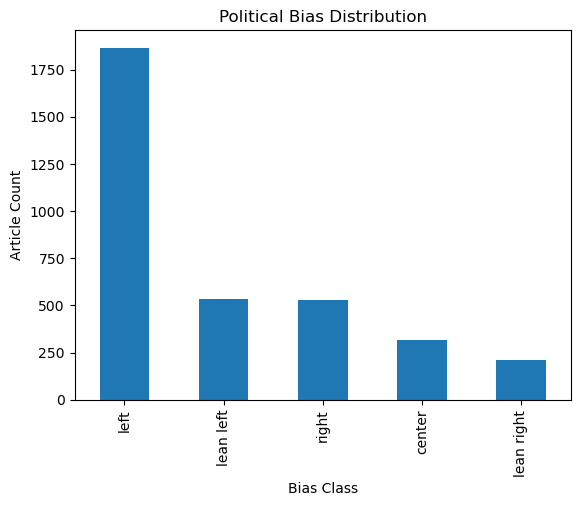

In [9]:
df['Bias'].value_counts().plot(kind='bar', title='Political Bias Distribution')
plt.xlabel("Bias Class")
plt.ylabel("Article Count")
plt.show()

There is a clear class imbalance in the Bias column, with the left class significantly overrepresented compared to lean right and right, which may affect model fairness and performance.

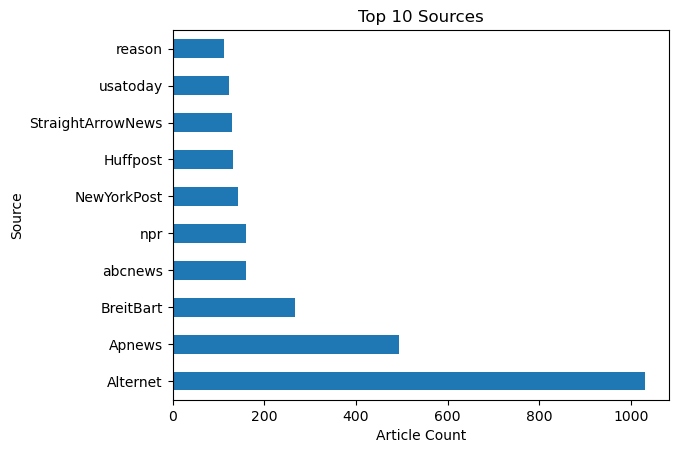

In [10]:
# Source Distribution
df['Source'].value_counts().head(10).plot(kind='barh', title='Top 10 Sources')
plt.xlabel("Article Count")
plt.show()


In [11]:
df['Source'].value_counts()

Source
Alternet                    1031
Apnews                       493
BreitBart                    267
abcnews                      161
npr                          160
NewYorkPost                  142
Huffpost                     131
StraightArrowNews            130
usatoday                     124
reason                       111
TheFederalist                110
nbcnews                       89
cnbc                          78
IndependentJournalReview      78
TheDailyBeast                 77
TheNation                     70
MotherJones                   63
TheFreePress                  52
TheWashingtonFreeBeacon       39
BlazeMedia                    35
TheDispatch                   17
Name: count, dtype: int64

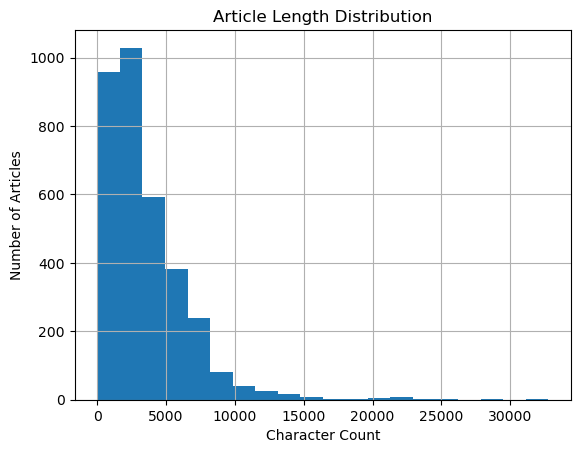

In [12]:
# Article Length Distribution
df['Text_Length'] = df['Text'].str.len()
df['Text_Length'].hist(bins=20)
plt.title("Article Length Distribution")
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
plt.show()


Since the article length distribution is left-skewed and unimodal, and over 1,000 articles have at least 2,500 characters, we can expect rich text data, making thorough preprocessing—like stopword removal and stemming—a good next step for reducing noise

### Data Cleaning

In [13]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    if pd.isna(text) or text == "Error fetching article":
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(f"[{string.punctuation}]", '', text)  # remove punctuation
    tokens = text.split()  # split into words
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# Apply cleaning
df['clean_text'] = df['Text'].apply(clean_text)

# Optional: remove rows with blank clean_text
df = df[df['clean_text'].str.strip() != '']

In [22]:
# Length of original and cleaned text
df['original_length'] = df['Text'].str.len()
df['clean_length'] = df['clean_text'].str.len()

df['original_length'].value_counts().sort_values()


original_length
5476    1
2444    1
2019    1
4941    1
2216    1
       ..
956     5
2354    5
2222    6
2546    6
2789    6
Name: count, Length: 2069, dtype: int64

In [23]:

df['clean_length'].value_counts().sort_values()


clean_length
5424     1
2312     1
2898     1
1627     1
7084     1
        ..
1291     6
1267     6
1451     6
1534     8
1512    13
Name: count, Length: 1884, dtype: int64

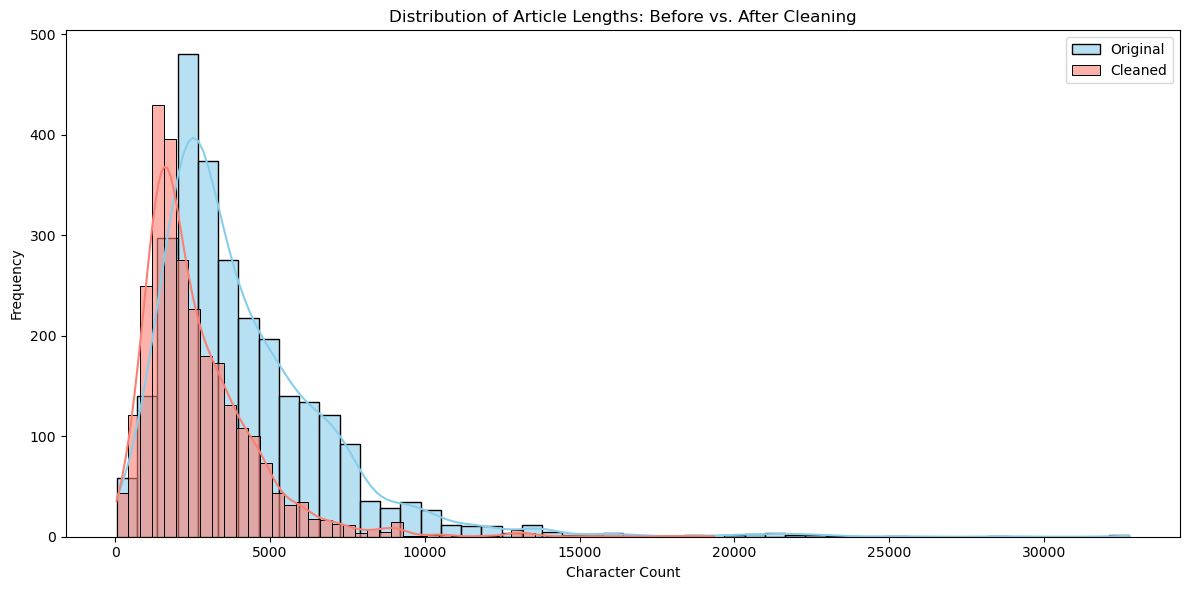

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Original article lengths
sns.histplot(df['original_length'], bins=50, kde=True, color='skyblue', label='Original', alpha=0.6)

# Cleaned article lengths
sns.histplot(df['clean_length'], bins=50, kde=True, color='salmon', label='Cleaned', alpha=0.6)

plt.title('Distribution of Article Lengths: Before vs. After Cleaning')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
print(df[['original_length', 'clean_length']].describe())


       original_length  clean_length
count      2738.000000   2738.000000
mean       4179.565011   2676.146092
std        3010.757339   1918.198051
min          51.000000     39.000000
25%        2276.250000   1470.000000
50%        3377.000000   2138.000000
75%        5346.500000   3420.000000
max       32759.000000  19329.000000


### Saving the Clean Data
- Save the processed data for future use.

In [25]:
df.to_csv('../data/cleaned_df.csv')